<a href="https://colab.research.google.com/github/antomys/Face_Recognition/blob/master/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%autosave 30
%matplotlib inline

Autosaving every 30 seconds


### Підготовка
Імпорт потрібних ліб

In [ ]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path

# Піллов (Пітонівська ліба для картинок)
from PIL import Image  
from keras.models import load_model


# Класифікатор СВМ з СВЦ для класифікації на різних обличчах
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.metrics import accuracy_score

from platform import python_version

Імпорт MCTNN для детекції обличчя та рис

In [ ]:
# Multi-task Cascaded Convolutional Networks (MTCNN)
!pip install MTCNN
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
# Ваги - звичайні дефолтні

## Датасет
Для роботи було використано датасет з ресурсу kaggle

In [ ]:
# original dataset folder, you can see above. Костыль из прошлой работы
# We are using this dataset already splitted into train and valid databsets because google drive and colab are very bad with each other.
dataset_name = '5-celebrity-faces-dataset'
dirStr = '/content/drive/MyDrive/5-celebrity-faces-dataset'
base_dir = Path(dirStr)
print (base_dir)

sub_dir_name = [dirs for dirs in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, dirs))]
print(f"sub_directories are {sub_dir_name}")


/content/drive/MyDrive/5-celebrity-faces-dataset
sub_directories are ['data', 'val', 'train', 'keras']


keras facenet models

In [ ]:
path_saved_model_string = dirStr + "/keras/model/facenet_keras.h5"
path_saved_model = Path(path_saved_model_string)
print (path_saved_model)

facenet_model = load_model(path_saved_model)

print(f"Input: {facenet_model.inputs}")
print(f"Output: {facenet_model.outputs}")

/content/drive/MyDrive/5-celebrity-faces-dataset/keras/model/facenet_keras.h5
Input: [<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
Output: [<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


Процесинг даних:

In [ ]:
base_dir_train  = os.path.join(base_dir, 'train'+'/')
base_dir_data_sting = dirStr + "/data/"
base_dir_data   = os.path.join(base_dir_data_sting)
print (base_dir_data_sting)
base_dir_val    = os.path.join(base_dir, 'val'+'/')

print (base_dir_train)
sub_sub_dir = os.listdir(os.path.join(base_dir,base_dir_train))

base_dir_anne = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'anne' in fn])+'/')
base_dir_arnold = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'arnold' in fn])+'/')
base_dir_ben = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'ben' in fn])+'/')
base_dir_dwayne = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'dwayne' in fn])+'/')
base_dir_elton = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'elton' in fn])+'/')
base_dir_jerry = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'jerry' in fn])+'/')
base_dir_kate = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'kate' in fn])+'/')
base_dir_keanu = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'keanu' in fn])+'/')
base_dir_lauren = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'lauren' in fn])+'/')
base_dir_madonna = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'madonna' in fn])+'/')
base_dir_mindy = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'mindy' in fn])+'/')
base_dir_simon = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'simon' in fn])+'/')
base_dir_sofia = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'sofia' in fn])+'/')
base_dir_will = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'will' in fn])+'/')


/content/drive/MyDrive/5-celebrity-faces-dataset/data/
/content/drive/MyDrive/5-celebrity-faces-dataset/train/


Графік частоти

In [ ]:
def draw_name_frequency_plot(directory):
    
    labels = [subdir.replace("_", " ").title() for subdir in os.listdir(directory) if os.path.isdir(os.path.join(directory,subdir))]
    label_count = [len(os.listdir(os.path.join(directory, subdir))) for subdir in os.listdir(directory) if os.path.isdir(os.path.join(directory,subdir)) ]
            
    c = ['green', 'yellow', 'cyan', 'gray', 'orange','olive','sandybrown','plum']
    plt.rcParams["figure.figsize"] = (40,5)
    plt.bar(labels, label_count, color=c)
    plt.ylabel('count', fontsize=20)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    plt.grid(True, linewidth= 1, linestyle="--")
    plt.show()  

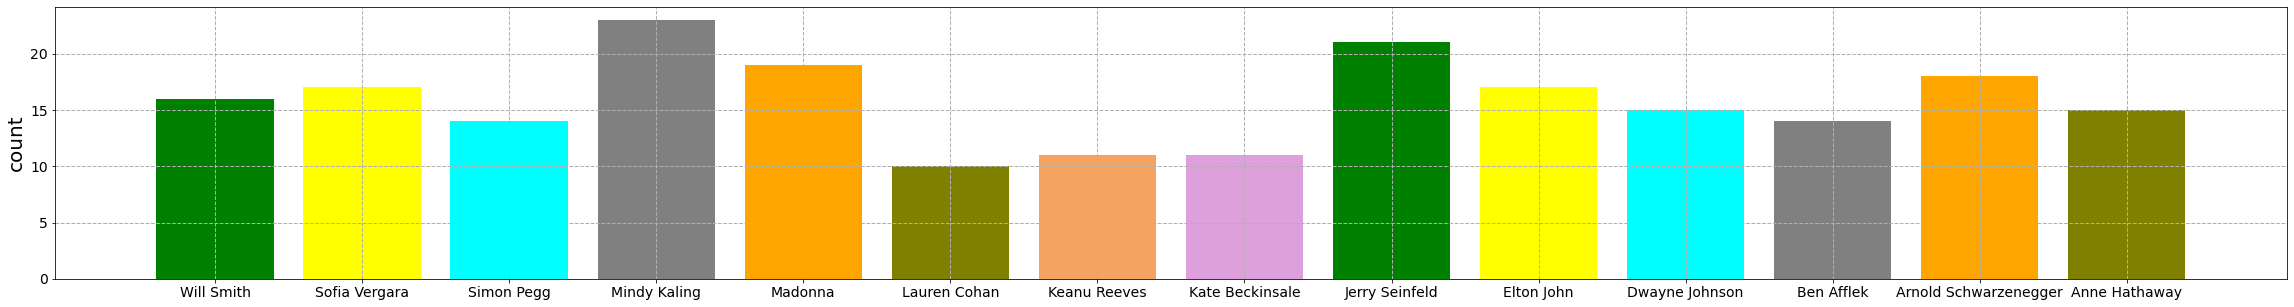

In [ ]:
draw_name_frequency_plot(base_dir_train)

## Вилучення рис обличчя

Детектор повертає список об'єктів JSON. Кожен об'єкт JSON містить три основні
  ключі: 'box', 'confidence' та 'keypoints'

*   Обмежувальний бокс відформатований як [x, y, width, height в змінній "box".
*   Достовірність - це ймовірність того, що обмежувальний бокс буде відповідати обличчю
*   Ключові точки форматуються в об'єкт JSON з ключами "left_eye", "right_eye", "nose", "mouth_left", "mouth_right". Кожна ключова точка визначається положенням пікселя (x, y).

In [ ]:
def draw_face_boundaries(image, feature_coordinate):
    filename = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    bounding_box = feature_coordinate[0]['box']
    keypoints = feature_coordinate[0]['keypoints']
    cv2.rectangle(filename,
                  (bounding_box[0], bounding_box[1]),
                  (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                  (0,155,255),
                  2)
    cv2.circle(filename,(keypoints['left_eye']),   2, (0,155,255), 2)
    cv2.circle(filename,(keypoints['right_eye']),  2, (0,155,255), 2)
    cv2.circle(filename,(keypoints['nose']),       2, (0,155,255), 2)
    cv2.circle(filename,(keypoints['mouth_left']), 2, (0,155,255), 2)
    cv2.circle(filename,(keypoints['mouth_right']),2, (0,155,255), 2)
    cv2.imwrite(image, cv2.cvtColor(filename, cv2.COLOR_RGB2BGR))
    plt.imshow(filename)

In [ ]:
def extract_face(filename,required_size=(160, 160), print_features=False, show_features=False): 
    
    # pre-processing on file image
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)

    face_coordinates = detector.detect_faces(pixels)
    
    if show_features:
        draw_face_boundaries(filename, face_coordinates)
    if print_features:
        print(f"> Extracted features: \n {face_coordinates}")

    x1, y1, width, height = face_coordinates[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # extract the face
    face = pixels[y1:y2, x1:x2]
    
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    
    return face_array

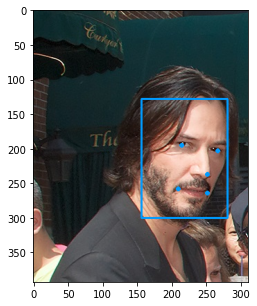

In [ ]:
# Завантаження фото та екстракція обличчя
pixels = extract_face(base_dir_keanu + os.listdir(base_dir_keanu)[0],  show_features=True)

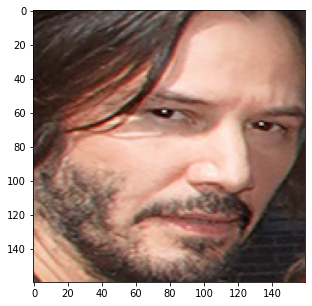

In [ ]:
plt.imshow(pixels)

In [ ]:
def extract_all_faces(directory, show_points=False, show_print=False):
    nrows = 4
    ncols = round(len(os.listdir(directory)) / nrows) + 1
    
    for count, filename in enumerate(os.listdir(directory)):
        path = directory + "/" + filename
        face = extract_face(path, show_features=show_points, print_features=show_print)
        plt.subplot(nrows, ncols, count+1)
        plt.axis('off')
        plt.imshow(face)
    plt.show()

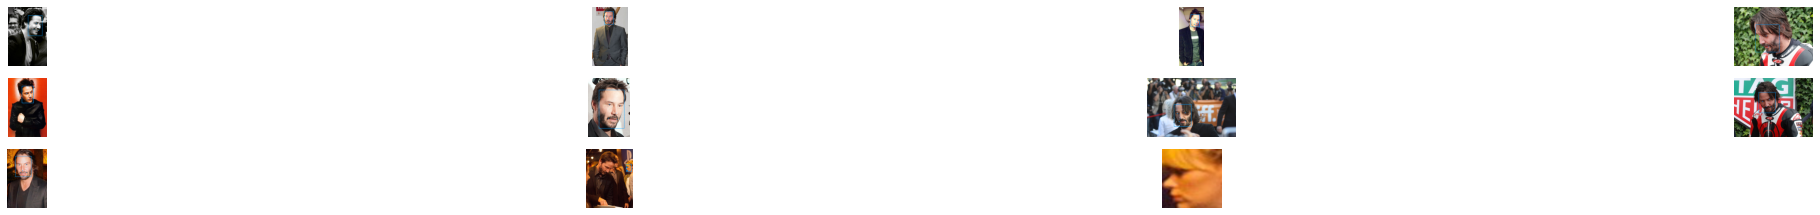

In [ ]:
extract_all_faces(directory=base_dir_keanu, show_points=True)

In [ ]:
# завантаження датасету, який містить одну піддиректорію для кожного класу, який в свою чергу містить картинки
def load_dataset(directory):
    X, y = [],[] 

    for subdir in os.listdir(directory):
        path = directory + subdir + '/'

        # скіп директорій
        if not os.path.isdir(path):
            continue

        faces = [extract_face(path+subpath) for subpath in os.listdir(path)]        
        labels = [subdir for _ in range(len(faces))]
        
        print(f'>loaded {len(faces)} examples for class: {subdir}')
        
        X.extend(faces)
        y.extend(labels)
        
    return np.asarray(X), np.asarray(y)

In [ ]:
# власне завантаження датасету
trainX, trainy = load_dataset(base_dir_train)
testX,   testy = load_dataset(base_dir_val)
print(f"train=> X.shape: {trainX.shape}, y.shape: {trainy.shape}")
print(f"test=> X.shape: {testX.shape}, y.shape: {testy.shape}")

>loaded 16 examples for class: will_smith
>loaded 17 examples for class: sofia_vergara
>loaded 14 examples for class: simon_pegg
>loaded 23 examples for class: mindy_kaling
>loaded 19 examples for class: madonna
>loaded 10 examples for class: lauren_cohan
>loaded 11 examples for class: keanu_reeves
>loaded 11 examples for class: kate_beckinsale
>loaded 21 examples for class: jerry_seinfeld
>loaded 17 examples for class: elton_john
>loaded 15 examples for class: dwayne_johnson
>loaded 14 examples for class: ben_afflek
>loaded 18 examples for class: arnold_schwarzenegger
>loaded 15 examples for class: anne_hathaway
>loaded 5 examples for class: will_smith
>loaded 6 examples for class: sofia_vergara
>loaded 5 examples for class: simon_pegg
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: madonna
>loaded 4 examples for class: lauren_cohan
>loaded 5 examples for class: keanu_reeves
>loaded 4 examples for class: kate_beckinsale
>loaded 5 examples for class: jerry_sein

## Моделювання

# Facenet

In [ ]:
def get_128vectorEmbedding_singleImage(model, face_pixels):
    # скейлинг пікселей
    face_pixels = face_pixels.astype('float32')
    
    # нормалізація пікселей по всіх каналах
    face_pixels_normalized = (face_pixels - face_pixels.mean()) / face_pixels.std()
    
    # трансформування обличчя в один приклад
    samples = np.expand_dims(face_pixels_normalized, axis=0)
    
    # предікшн для ембеддингу
    yhat = model.predict(samples)
    
    return yhat[0]

In [ ]:
# вертає фейс ембединг для всього трейн датасету
def get_embedding_dataset(model, train_X, test_X):
    
    embTrain_X = [get_128vectorEmbedding_singleImage(model, face_pixels) for face_pixels in train_X]
    embTest_X  = [get_128vectorEmbedding_singleImage(model, face_pixels) for face_pixels in test_X]
    
    print(f'embTrain_X shape: {np.asarray(embTrain_X).shape}, embText_X shape: {np.asarray(embTest_X).shape}')
    
    return np.asarray(embTrain_X), np.asarray(embTest_X)

In [ ]:
embTrain_X, embTest_X = get_embedding_dataset(model=facenet_model, train_X=trainX, test_X=testX)

embTrain_X shape: (221, 128), embText_X shape: (70, 128)


# SVM

In [ ]:
def normalize_vectors(vectors):
    """ normalize input vectors """ 
    normalizer = Normalizer(norm='l2')
    vectors = normalizer.transform(vectors)

    return vectors

In [ ]:
def labels_encoder(labels):
    """provide one hot encoding of incoming labels"""
    out_encoder = LabelEncoder()
    out_encoder.fit(labels)
    labels = out_encoder.transform(labels)
    return out_encoder, labels

In [ ]:
def svm_classifier(train_x_embedding, train_y, test_x_embedding, test_y):

    # normalize input vectors
    train_x_norm_embedding   = normalize_vectors(train_x_embedding)
    test_x_norm_embedding    = normalize_vectors(test_x_embedding)

    # label encode targets 
    out_encoder, train_y_class = labels_encoder(train_y)
    out_encoder, test_y_class  = labels_encoder(test_y)

    # fit model
    model       = SVC(kernel='linear', probability=True)
    model.fit(train_x_norm_embedding, train_y_class)
    
    yhat_train  = model.predict(train_x_norm_embedding)
    yhat_test   = model.predict(test_x_norm_embedding)
    
    score_train = accuracy_score(train_y_class, yhat_train)
    score_test  = accuracy_score(test_y_class, yhat_test)
    print(f'Accuracy: train={score_train*100}, test={score_test*100}')
    
    return model

In [ ]:
svm_model= svm_classifier(embTrain_X, trainy, embTest_X, testy)

Accuracy: train=100.0, test=98.57142857142858


In [ ]:
## save svm
try:
    import dill as pickle
except ImportError:
    import pickle
tempStr = Path(path_saved_model_string + "Faces.pkl")
with open(tempStr,'wb') as file_pi:
    pickle.dump(svm_model, file_pi)

## Тестування

In [ ]:
def random_testing_test_data(test_data, test_label, embedding_model, classification_model) :
    # test model on a random example from the test dataset
    selection          = random.choice([i for i in range(test_data.shape[0])])

    random_face_pixels = get_128vectorEmbedding_singleImage(embedding_model, test_data[selection])
    random_face_pixels = np.expand_dims(random_face_pixels, axis=0)
    random_face_emb    = normalize_vectors(random_face_pixels)

    label_encoder, test_y_class  = labels_encoder(test_label)
    random_face_class            = test_y_class[selection]
    random_face_name             = label_encoder.inverse_transform([random_face_class])

    # prediction for the face
    yhat_class = classification_model.predict(random_face_emb)
    yhat_prob  = classification_model.predict_proba(random_face_emb)

    # get name
    class_index       = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    predict_names     = label_encoder.inverse_transform(yhat_class)
    print(f'Predicted: {predict_names[0].replace("_"," ").title()} confidence:({round(class_probability,2)})')
    print(f'Expected: {random_face_name[0].replace("_"," ").title()}')

    # ploting
    plt.imshow(test_data[selection])
    title = f'{predict_names[0].replace("_"," ").title()} ({round(class_probability,2)})'
    plt.title(title)
    plt.show()

Predicted: Anne Hathaway confidence:(67.87)
Expected: Anne Hathaway


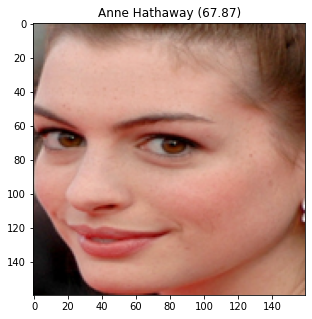

In [ ]:
random_testing_test_data(testX, testy, facenet_model, svm_model)

In [ ]:
# завантаження моделі
path_saved_model = dirStr
svm_model = pickle.load(open(path_saved_model_string + "Faces.pkl", "rb"))
facenet_model=load_model(Path(path_saved_model_string))

In [ ]:
def extract_labels(directory):
    y = []
    for subdir in os.listdir(directory):
        path = directory + subdir + '/'
        if not os.path.isdir(path):
            continue
        range_dir = [subpath for subpath in os.listdir(path)]
        labels = [subdir for _ in range(len(range_dir))]
        y.extend(labels)
    return np.asarray(y)

def load_labels():
    base_dir = dirStr
    dataset_path = os.path.join(base_dir, 'train/')
    labels = extract_labels(dataset_path)
    return labels

labels = load_labels()

In [ ]:
def externaly_uploaded_face(image, test_label, embedding_model, classifiation_model, threshold=80):
    image_pixels = extract_face(image, show_features=False)
    emb_image    = get_128vectorEmbedding_singleImage(embedding_model, image_pixels)
    print(emb_image)

    # prediction for the face
    samples_image = np.expand_dims(emb_image, axis=0)
    yhat_class    = classifiation_model.predict(samples_image)
    yhat_prob     = classifiation_model.predict_proba(samples_image)

    # setup encoder for test images    
    label_encoder, test_y_class  = labels_encoder(test_label)

    # get name
    class_index       = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    
    if class_probability >= threshold:
        predicted_name = label_encoder.inverse_transform(yhat_class)[0]
    else:
        predicted_name = 'Unknown'
    
    plt.imshow(image_pixels)
    title = f'{predicted_name.replace("_"," ").title()} ({round(class_probability,2)})'
    plt.title(title)
    print(f'Predicted: {predicted_name.replace("_"," ").title()} confidence:({round(class_probability,2)})')
    plt.show()

In [ ]:
os.listdir(base_dir_data)

['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']

elton_john
httpftqncomymusicLxZeltonjohnjpg.jpg
/content/drive/MyDrive/5-celebrity-faces-dataset/data/elton_john/httpftqncomymusicLxZeltonjohnjpg.jpg
[ 1.0902386  -0.62603104 -1.1077898   0.34553647  0.9459218   0.6342144
 -0.2335327  -0.6445694   0.5008793   0.76252663  0.11376094  0.83764565
  1.33268    -0.23565215 -1.0433711   0.46953917  0.05349955 -1.1553155
 -0.14846303  0.03852192 -0.3866114  -0.6658171   0.29876363  0.42792413
  2.1200597  -0.04423235  0.39361358  1.6636221  -1.404698   -0.1487847
 -0.2292577  -0.16812952 -0.70281523  0.11249075 -0.86804897  0.9651268
 -0.8495125  -0.76209307 -1.2329996   0.83766043  1.8756564   1.1167433
  1.0806788   1.1757413   0.69108516 -1.618938   -0.24525079  1.7211715
  0.14022627 -1.1070199   0.6596758  -0.3321947  -1.1760557  -0.31836817
 -0.7204611   0.5439097   0.98397756 -0.7943498  -0.7666157   0.22981039
  1.2304262   0.46177912  0.12038502  0.55458397  0.23565868 -0.34808332
 -1.2891147   0.1712691  -0.03822806 -0.49280906  0.1

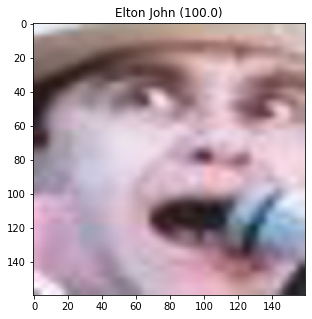

In [ ]:
imageFolder = os.listdir(base_dir_data)[1]
print(imageFolder)
image = os.listdir(base_dir_data_sting + imageFolder)[0]
print(image)
image_path = base_dir_data_sting + imageFolder + '/' + image
print(image_path)
externaly_uploaded_face(image_path, labels, facenet_model, svm_model, threshold=80)

ben_afflek
6171279833f4b300189ad407.jpg
/content/drive/MyDrive/5-celebrity-faces-dataset/data/ben_afflek/6171279833f4b300189ad407.jpg
[-0.57661045  0.984959    0.9533627  -1.3408836   0.49824405  1.4863181
 -0.12790625  0.5118755   1.0946969  -0.807067    0.9247993  -0.40200526
 -1.5290177   0.32466838 -0.18045413  0.1440936  -2.6962852  -1.6525437
 -0.3396457   0.15732956  1.7583699  -0.08185119  0.67029715 -0.5785131
  0.84059083 -1.127218   -0.27447107 -1.8759671  -0.78052396 -1.189114
 -0.30976108 -2.0517113   0.48046318  0.3577767  -0.35455173  0.3195674
 -0.25214708 -0.596499    1.6482406  -0.26628786 -0.2759446  -0.7887566
 -1.462276   -0.88654065 -1.6394535   0.05955991 -1.5491467   0.9561626
 -0.34041992 -0.46903732 -1.1940792   2.3642046   1.1458207  -0.8263962
  0.20701224 -0.3612144   1.8492688  -0.6505212   0.27692357  0.8578901
  0.98277706 -0.17959812 -0.83618027  0.1101831   1.032986   -0.6819553
  0.44555643  0.08470138 -2.1952958   0.87539583 -0.61047935 -0.4207352
 -

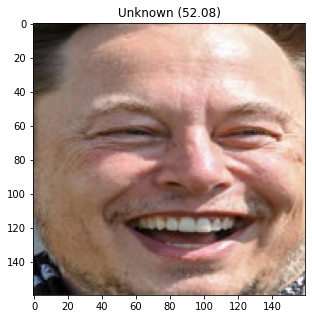

In [ ]:
imageFolder = os.listdir(base_dir_data)[0]
print(imageFolder)
image = os.listdir(base_dir_data_sting + imageFolder)[1]
print(image)
image_path = base_dir_data_sting + imageFolder + '/' + image
print(image_path)
externaly_uploaded_face(image_path, labels, facenet_model, svm_model, threshold=80)